In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as cross_validation
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
file = r'''/Users/aaronhxzhang/AARD/Data/OneHotEncodingCrashData.xlsx'''
data = pd.ExcelFile(file)
crash_df = data.parse('Sheet1')
print(list(crash_df))
print(crash_df.shape)

['Crash Number', 'Crash Date', 'Crash Time', 'Crash Hour', 'City/Town', 'Locality', 'Crash Severity', 'Maximum Injury Severity Reported', 'Number of NonFatal Injuries', 'Number of Fatal Injuries', 'Number of Vehicles', 'Manner of Collision', 'Age of Driver - Youngest Known', 'Age of Driver - Oldest Known', 'Hit & Run', 'Road Surface', 'Ambient Light', 'Weather Condition', 'Traffic Way', 'Speed Limit', 'Roadway Intersection Type', 'Linked RI Number of Travel Lanes', 'Linked RI Street Operation', 'Linked RI Average Daily Traffic', 'Linked RI Year of ADT', 'X', 'Y', 'Road Segment ID', 'County']
(1063, 29)


In [3]:
crash_df = crash_df.drop(columns='Crash Time')
crash_df = crash_df.drop(columns='Crash Date')
crash_df = crash_df.drop(columns='Crash Number')
crash_df = crash_df.drop(columns='X')
crash_df = crash_df.drop(columns='Y')
crash_df = crash_df.drop(columns='County')
crash_df = crash_df.drop(columns='Locality')
crash_df = crash_df.drop(columns='Maximum Injury Severity Reported') #Later down in the code, it was revealed that this strongly correlated with nonfatal injuries (but these are basically the same thing)
crash_df = crash_df.drop(columns='Crash Severity') #This correlates strongest with nonfatal injuries (so need to remove) but for a different test (ex. relationship between crash type and severity), need to add this category back in

In [4]:
crash_df.sample(6)

,Crash Hour,City/Town,Number of NonFatal Injuries,Number of Fatal Injuries,Number of Vehicles,Manner of Collision,Age of Driver - Youngest Known,Age of Driver - Oldest Known,Hit & Run,Road Surface,Ambient Light,Weather Condition,Traffic Way,Speed Limit,Roadway Intersection Type,Linked RI Number of Travel Lanes,Linked RI Street Operation,Linked RI Average Daily Traffic,Linked RI Year of ADT,Road Segment ID
540,06:00PM to 06:59PM,ACTON,0,0,2,Angle,21-24,35-44,No hit and run,Dry,Dark - lighted roadway,Clear,"Two-way, not divided",0,Not at junction,2,Two-way traffic,8006,2013,1826
83,07:00AM to 07:59AM,ACTON,0,0,1,Single vehicle crash,45-54,45-54,No hit and run,Snow,Daylight,Clear,Not reported,25,Not reported,2,Two-way traffic,3175,2009,1441
90,11:00PM to 11:59PM,ACTON,0,0,1,Single vehicle crash,25-34,25-34,No hit and run,Ice,Dark - lighted roadway,"Snow/Sleet, hail (freezing rain or drizzle)","Two-way, not divided",30,Not at junction,2,Two-way traffic,3000,0,2019
39,05:00PM to 05:59PM,ACTON,0,0,1,Single vehicle crash,45-54,45-54,No hit and run,Dry,Daylight,Clear/Clear,"Two-way, not divided",35,Not reported,2,Two-way traffic,12100,2009,1503
732,08:00AM to 08:59AM,ACTON,0,0,2,Head-on,21-24,35-44,No hit and run,Dry,Daylight,Clear,"Two-way, divided, unprotected median",0,Not at junction,2,Two-way traffic,749,2013,2093
630,05:00PM to 05:59PM,ACTON,0,0,2,Angle,21-24,25-34,No hit and run,Dry,Daylight,Clear/Clear,"Two-way, not divided",40,T-intersection,2,Two-way traffic,17028,2013,1519


In [6]:
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '1', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '2', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '3', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '4', '1+', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries']=np.where(crash_df['Number of NonFatal Injuries'] == '0', 'none', crash_df['Number of NonFatal Injuries'])
crash_df['Number of NonFatal Injuries'].unique()

array(['none', '1+'], dtype=object)

In [7]:
def summarize_data(df):
    for column in df.columns:
            print(column)
            if df.dtypes[column] == np.object:    #categorical data
                print(df[column].value_counts())
            else:
                print (df[column].describe())
                
            print ('\n')
            
summarize_data(crash_df)


Crash Hour
03:00PM to 03:59PM    98
04:00PM to 04:59PM    96
06:00PM to 06:59PM    96
05:00PM to 05:59PM    87
02:00PM to 02:59PM    72
08:00AM to 08:59AM    71
12:00PM to 12:59PM    71
11:00AM to 11:59AM    68
01:00PM to 01:59PM    63
09:00AM to 09:59AM    53
07:00AM to 07:59AM    52
10:00AM to 10:59AM    49
07:00PM to 07:59PM    48
06:00AM to 06:59AM    35
09:00PM to 09:59PM    23
11:00PM to 11:59PM    17
08:00PM to 08:59PM    15
10:00PM to 10:59PM    14
05:00AM to 05:59AM    12
12:00AM to 12:59AM     5
01:00AM to 01:59AM     5
03:00AM to 03:59AM     5
02:00AM to 02:59AM     4
04:00AM to 04:59AM     4
Name: Crash Hour, dtype: int64


City/Town
ACTON    1063
Name: City/Town, dtype: int64


Number of NonFatal Injuries
none    821
1+      242
Name: Number of NonFatal Injuries, dtype: int64


Number of Fatal Injuries
count    1063.000000
mean        0.003763
std         0.061256
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name:

# Encode the Categorical Features as Numbers

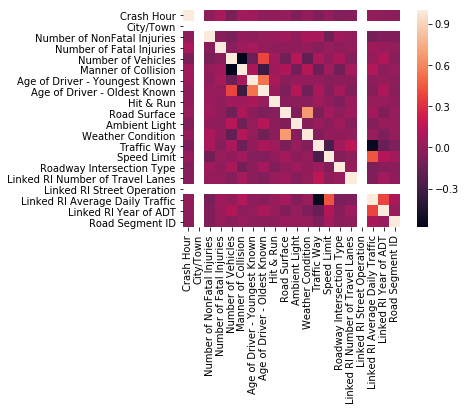

,Crash Hour,City/Town,Number of NonFatal Injuries,Number of Fatal Injuries,Number of Vehicles,Manner of Collision,Age of Driver - Youngest Known,Age of Driver - Oldest Known,Hit & Run,Road Surface,Ambient Light,Weather Condition,Traffic Way,Speed Limit,Roadway Intersection Type,Linked RI Number of Travel Lanes,Linked RI Street Operation,Linked RI Average Daily Traffic,Linked RI Year of ADT,Road Segment ID
1053,18,0,1,1,1,7,5,5,0,0,4,0,3,45,6,2,0,34428,2013,2088
1054,1,0,0,0,1,7,1,1,0,7,4,15,2,55,3,2,0,34428,2013,1931
1055,7,0,1,0,2,0,1,4,0,7,1,15,2,55,3,2,0,34428,2013,1931
1056,23,0,0,0,2,3,2,4,0,0,4,0,3,0,3,2,0,16653,2013,2047
1057,23,0,1,0,1,7,1,1,0,7,4,15,2,55,3,2,0,34428,2013,1931
1058,11,0,1,0,1,0,4,4,0,0,0,1,4,30,3,2,0,16445,2013,2135
1059,7,0,1,0,2,5,4,5,0,0,5,1,4,35,3,2,0,16445,2013,2135
1060,11,0,1,0,2,3,3,5,0,0,1,0,1,0,6,2,0,16445,2013,2086
1061,3,0,1,0,3,3,0,2,0,7,2,18,4,30,8,2,0,3129,2013,2083
1062,3,0,1,0,2,6,1,2,0,7,4,16,2,0,3,2,0,34428,2013,1931


In [8]:
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

#Calculate the correlation and plot it
encoded_data, _ = number_encode_features(crash_df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.tail(10)

In [9]:
#Strong correlation between oldest driver and manner of collision shown by heatmap
crash_df[["Age of Driver - Oldest Known", "Manner of Collision"]].head(10)

,Age of Driver - Oldest Known,Manner of Collision
0,16-20,Single vehicle crash
1,45-54,Angle
2,45-54,Single vehicle crash
3,25-34,Single vehicle crash
4,25-34,Unknown
5,65-74,"Sideswipe, same direction"
6,65-74,Rear-end
7,35-44,Angle
8,25-34,Single vehicle crash
9,25-34,Single vehicle crash


In [10]:
#Explore strong correlation between weather condition and road surface
crash_df[["Weather Condition", "Road Surface"]].head(10)

,Weather Condition,Road Surface
0,Clear/Clear,Wet
1,Rain/Cloudy,Wet
2,Not Reported,Dry
3,Snow/Snow,Snow
4,Clear,Dry
5,Clear/Clear,Dry
6,Clear,Dry
7,Snow,Snow
8,Snow/Cloudy,Snow
9,Snow/Cloudy,Snow


In [11]:
#Looks kind of like the same data, however weather condition looks like it would produce more predictive data since it has more specific categories
#We will delete this later if we need to

In [12]:
encoded_data, encoders = number_encode_features(crash_df)
new_series = encoded_data["Number of NonFatal Injuries"]

In [13]:
#Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns.drop("Number of NonFatal Injuries")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


# Begin Logistic Regression

In [14]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
y_pred = cls.predict(X_test)

In [16]:
print(accuracy_score(y_test, y_pred))

0.7774294670846394


In [17]:
#Mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [18]:
print(fit_and_evaluate(cls))

0.2225705329153605


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
# Try random forest method
random_forest = RandomForestRegressor(random_state=60)
print(fit_and_evaluate(random_forest))

0.35705329153605037


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Index(['Crash Hour', 'City/Town', 'Number of Fatal Injuries',
       'Number of Vehicles', 'Manner of Collision',
       'Age of Driver - Youngest Known', 'Age of Driver - Oldest Known',
       'Hit & Run', 'Road Surface', 'Ambient Light', 'Weather Condition',
       'Traffic Way', 'Speed Limit', 'Roadway Intersection Type',
       'Linked RI Number of Travel Lanes', 'Linked RI Street Operation',
       'Linked RI Average Daily Traffic', 'Linked RI Year of ADT',
       'Road Segment ID'],
      dtype='object')


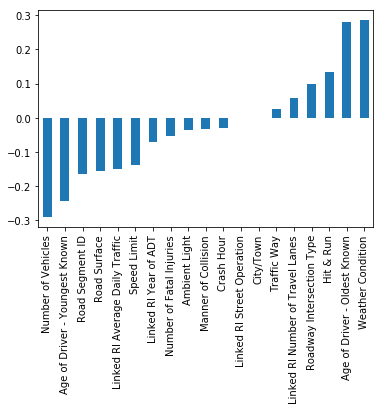

Weather Condition                   0.286713
Age of Driver - Oldest Known        0.280260
Hit & Run                           0.133549
Roadway Intersection Type           0.099435
Linked RI Number of Travel Lanes    0.058910
Traffic Way                         0.026487
City/Town                           0.000000
Linked RI Street Operation          0.000000
Crash Hour                         -0.031238
Manner of Collision                -0.031818
Ambient Light                      -0.036903
Number of Fatal Injuries           -0.052769
Linked RI Year of ADT              -0.070865
Speed Limit                        -0.137935
Linked RI Average Daily Traffic    -0.149021
Road Surface                       -0.154812
Road Segment ID                    -0.163574
Age of Driver - Youngest Known     -0.243217
Number of Vehicles                 -0.291274
dtype: float64


In [20]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print(X_train.columns)
coefs = coefs.sort_values()
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print(coefs.sort_values(ascending = False))

# Try one hot encoding

In [21]:
# Copy the original data
features = crash_df.copy()

# Select the numeric columns
numeric_subset = crash_df.select_dtypes('number')
categorical_subset = crash_df.select_dtypes('object')

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns.drop("Number of NonFatal Injuries")])

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print(features.head())

   Number of Fatal Injuries  Number of Vehicles  Speed Limit  \
0                         0                   1           30   
1                         0                   2           40   
2                         0                   1           25   
3                         0                   1           25   
4                         0                   1           30   

   Linked RI Number of Travel Lanes  Linked RI Average Daily Traffic  \
0                                 2                             3101   
1                                 2                            15082   
2                                 2                              700   
3                                 2                             7700   
4                                 2                             7700   

   Linked RI Year of ADT  Road Segment ID  Crash Hour_01:00AM to 01:59AM  \
0                   2013             1980                              0   
1                   2009      

In [22]:
# Replace the inf with nan
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Drop na values
features = features.dropna()

# Split and scale the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [23]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6959247648902821


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
print(fit_and_evaluate(cls))

0.30407523510971785


/Users/aaronhxzhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print(coefs.sort_values(ascending = False))

Weather Condition_Snow/Sleet, hail (freezing rain or drizzle)    0.590855
Road Surface_Ice                                                 0.506753
Age of Driver - Oldest Known_75-84                               0.465152
Weather Condition_Rain/Rain                                      0.439613
Manner of Collision_Unknown                                      0.352416
Weather Condition_Snow/Snow                                      0.335264
Age of Driver - Youngest Known_16-20                             0.322298
Weather Condition_Snow/Blowing sand, snow                        0.295555
Crash Hour_10:00PM to 10:59PM                                    0.283081
Road Surface_Slush                                               0.260811
Weather Condition_Cloudy/Clear                                   0.254933
Weather Condition_Snow/Cloudy                                    0.253511
Road Surface_Not reported                                        0.243501
Weather Condition_Not Reported        